In [1]:
from os.path import expanduser, join
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from black_box_tools.db_utils import DBUtils
from black_box_tools.data_utils import DataUtils, Filters
from black_box_tools.plot_utils import PlotUtils
from sklearn.mixture import BayesianGaussianMixture

In [2]:
def distance(x, y):
    return np.sqrt(np.sum(np.square(np.sqrt(x) - np.sqrt(y)))) / np.sqrt(2)

# Parameters

The following parameters should be set appropriately so that the correct data are read.

In [3]:
log_db_data_name = 'black_box_data'
faulty_log_db_data_name = 'faulty_black_box_data'
number_of_smart_wheels = 4

# Database restoring

In [4]:
DBUtils.restore_db('black_box_data/nominal_data/data',
                   db_name=log_db_data_name)

True

In [5]:
DBUtils.restore_db('black_box_data/faulty_data/data',
                   db_name=faulty_log_db_data_name)

True

# Data parsing

## Training and test data

The training data are the voltages from the first wheel of each smart wheel; the test data are all voltage measurements of the wheels (in this case, part of the test set is included in the training set, which is technically not a valid thing to do, but we still nevertheless want to check how the model performs on the training data as well).

In [6]:
sw_data_docs = DBUtils.get_all_docs(log_db_data_name,
                                    'ros_sw_ethercat_parser_data')
nominal_timestamps = DataUtils.get_all_measurements(sw_data_docs, 'timestamp')

# we extract all current measurements from the first wheel
train_data_sw1 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/0/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw2 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/1/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw3 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/2/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw4 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/3/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)

data = np.vstack((train_data_sw1, train_data_sw2,
                  train_data_sw3, train_data_sw4))

var_names = ['current1', 'current2', 'current3', 'current4']
(corr_vars, windowed_correlations) = DataUtils.get_windowed_correlations(var_names, data, window_size=100)

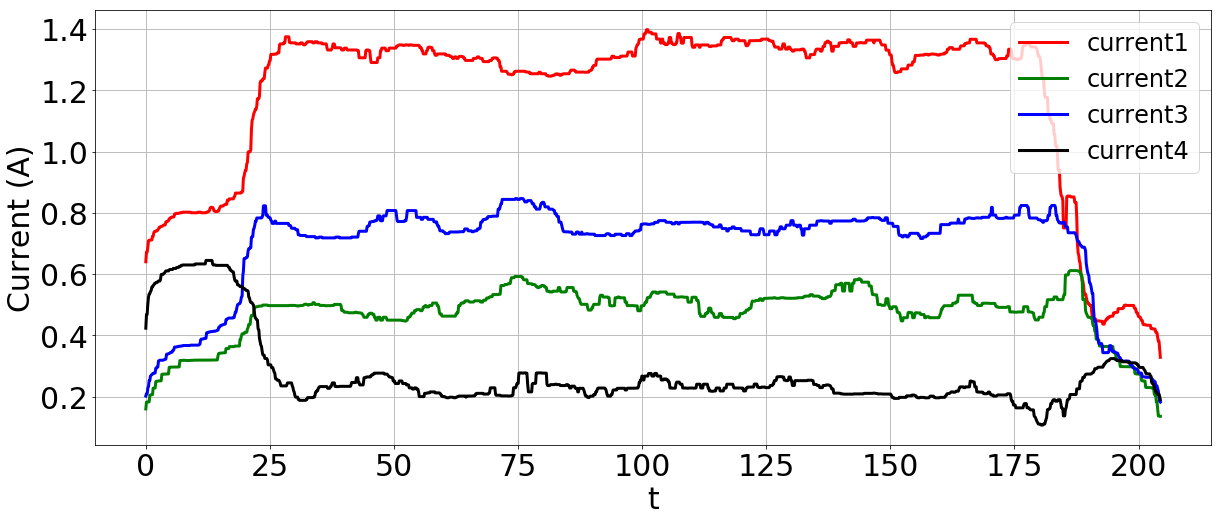

In [7]:
fig = plt.figure(figsize=(20, 8))
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw1, window_size=5), 'r', label='current1', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw2, window_size=5), 'g', label='current2', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw3, window_size=5), 'b', label='current3', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw4, window_size=5), 'k', label='current4', linewidth=3)

plt.xlabel('t', fontsize=30)
plt.ylabel('Current (A)', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=24)
plt.grid()
plt.show()

The test data look as shown below:

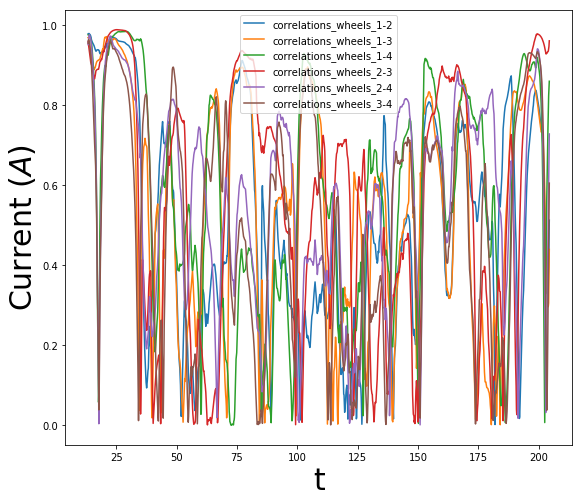

In [8]:
fig = plt.figure(figsize=(20, 8))

data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'correlations_wheels_{0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

PlotUtils.subplot_data_lists(fig=fig, subplot_params=(1,2,1),
                             timestamps=nominal_timestamps[99:]-nominal_timestamps[0],
                             data=windowed_correlations.T,
                             x_label='t', y_label='Current ($A$)',
                             data_labels=data_labels)

plt.show()

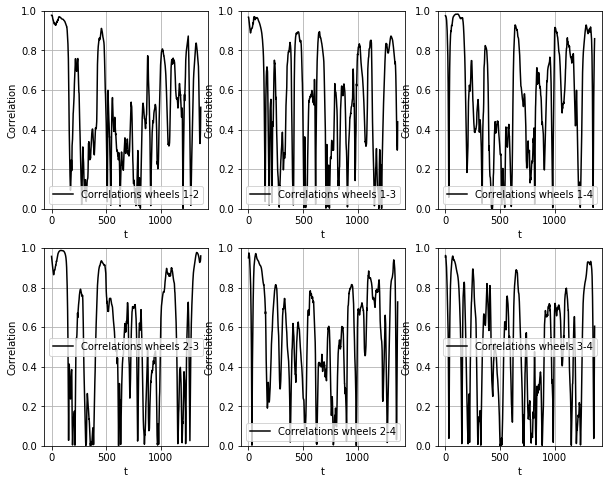

In [9]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'Correlations wheels {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot(windowed_correlations[i], 'k', label=data_labels[i])
    plt.xlabel('t')
    plt.ylabel('Correlation')
    plt.ylim([0, 1])
    plt.legend()
    plt.grid()
plt.show()

The faulty test data are also all voltage measurements, but in a sequence with an injected fault.

In [10]:
faulty_sw_data_docs = DBUtils.get_all_docs(faulty_log_db_data_name,
                                           'ros_sw_ethercat_parser_data')
faulty_timestamps = DataUtils.get_all_measurements(faulty_sw_data_docs, 'timestamp')

faulty_test_data_sw1 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/0/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw2 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/1/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw3 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/2/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw4 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/3/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)

faulty_data = np.vstack((faulty_test_data_sw1, faulty_test_data_sw2,
                         faulty_test_data_sw3, faulty_test_data_sw4))

var_names = ['current1', 'current2', 'current3', 'current4']
(corr_vars, faulty_windowed_correlations) = DataUtils.get_windowed_correlations(var_names, faulty_data, window_size=100)

In [11]:
event_docs = DBUtils.get_all_docs(faulty_log_db_data_name, 'ros_ropod_event')
event_timestamps = DataUtils.get_all_measurements(event_docs, 'timestamp')

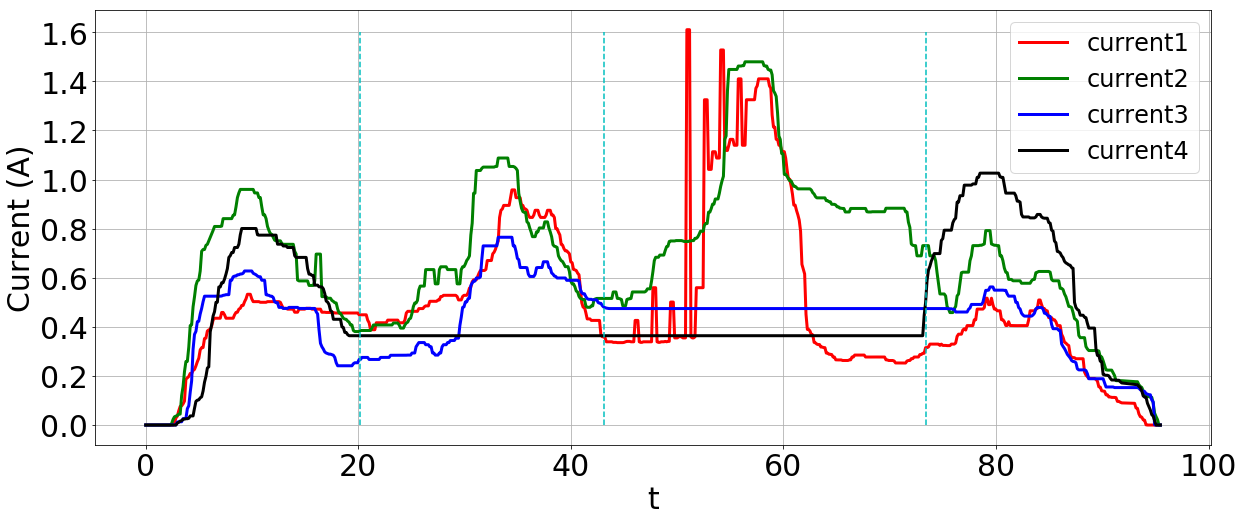

In [12]:
fig = plt.figure(figsize=(20, 8))
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw1, window_size=5), 'r', label='current1', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw2, window_size=5), 'g', label='current2', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw3, window_size=5), 'b', label='current3', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw4, window_size=5), 'k', label='current4', linewidth=3)

plt.plot([event_timestamps-faulty_timestamps[0]-3.5, event_timestamps-faulty_timestamps[0]-3.5], [0, 1.6], 'c--')

plt.xlabel('t', fontsize=30)
plt.ylabel('Current (A)', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=24)
plt.grid()
plt.show()

The faulty test data are plotted below:

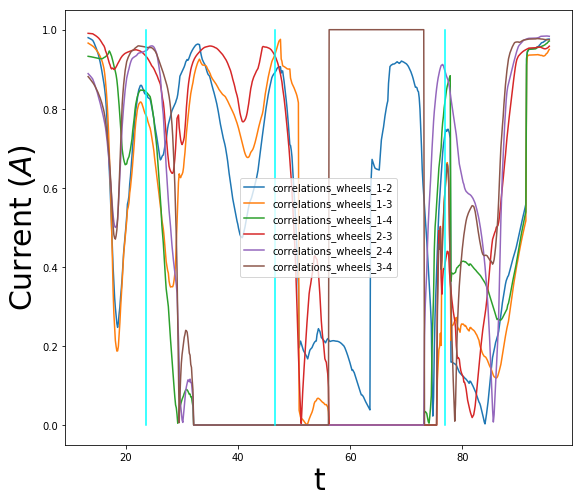

In [13]:
fig = plt.figure(figsize=(20, 8))

data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'correlations_wheels_{0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

PlotUtils.subplot_data_lists(fig=fig, subplot_params=(1,2,1),
                             timestamps=faulty_timestamps[99:]-faulty_timestamps[0],
                             data=faulty_windowed_correlations.T,
                             x_label='t', y_label='Current ($A$)',
                             data_labels=data_labels,
                             event_timestamps=event_timestamps-faulty_timestamps[0],
                             event_annotation_color='cyan')

plt.show()

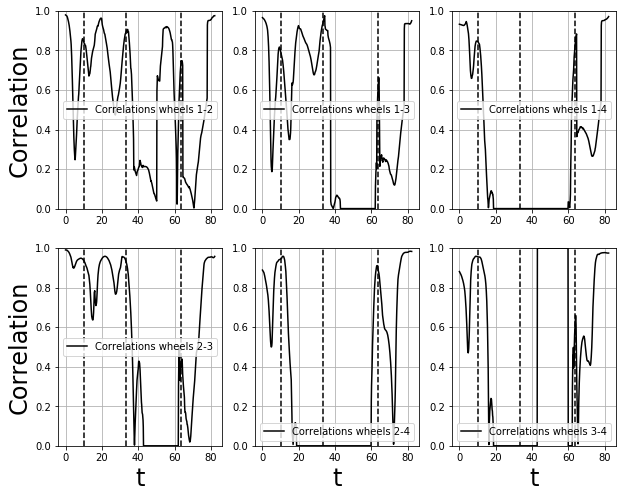

In [14]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'Correlations wheels {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot([], [], 'k--')
    plt.plot([event_timestamps-faulty_timestamps[99], event_timestamps-faulty_timestamps[99]], [0, 1],
             'k--')
    plt.plot(faulty_timestamps[99:]-faulty_timestamps[99], 
             faulty_windowed_correlations[i], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Correlation', fontsize=24)
    plt.ylim([0, 1])
    plt.legend()
    plt.grid()
plt.show()

# Model training

We now train our fault detection models:

In [17]:
sequence_len = 10
n_components = 5

model_sw12 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw12 = DataUtils.split_into_windows(windowed_correlations[0,:], sequence_len)
model_sw12 = model_sw12.fit(windowed_data_sw12)

model_sw13 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw13 = DataUtils.split_into_windows(windowed_correlations[1,:], sequence_len)
model_sw13 = model_sw12.fit(windowed_data_sw13)

model_sw14 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw14 = DataUtils.split_into_windows(windowed_correlations[2,:], sequence_len)
model_sw14 = model_sw12.fit(windowed_data_sw14)

model_sw23 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw23 = DataUtils.split_into_windows(windowed_correlations[3,:], sequence_len)
model_sw23 = model_sw12.fit(windowed_data_sw23)

model_sw24 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw24 = DataUtils.split_into_windows(windowed_correlations[4,:], sequence_len)
model_sw24 = model_sw12.fit(windowed_data_sw24)

model_sw34 = BayesianGaussianMixture(n_components=n_components)
windowed_data_sw34 = DataUtils.split_into_windows(windowed_correlations[5,:], sequence_len)
model_sw34 = model_sw12.fit(windowed_data_sw34)

/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [18]:
models = [model_sw12, model_sw13, model_sw14, model_sw23, model_sw24, model_sw34]

We now calculate the distances between the test data and the sampled data from the learned models:

In [19]:
distances_no_faults_w1 = list()
for i in range(len(models)):
    test_windowed_correlations = DataUtils.split_into_windows(windowed_correlations[i],
                                                              sequence_len)

    residuals = []
    for x in test_windowed_correlations:
        sample, _ = models[i].sample()
        residuals.append(distance(x, sample))
    distances_no_faults_w1.append(residuals)

distances_no_faults_w1 = np.array(distances_no_faults_w1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


We also calculate the distances between the faulty test data and the sampled data from the learned models:

In [21]:
faulty_distances_w1 = list()
for i in range(len(models)):
    faulty_test_windowed_correlations = DataUtils.split_into_windows(faulty_windowed_correlations[i],
                                                                     sequence_len)

    residuals = []
    for x in faulty_test_windowed_correlations:
        sample, _ = models[i].sample()
        residuals.append(distance(x, sample))
    faulty_distances_w1.append(residuals)

faulty_distances_w1 = np.array(faulty_distances_w1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


We calculate two thresholds based on the distances:
\begin{align*}
    t_{soft} = \mu_D - 3 * \sigma_D \\
    t_{hard} = \max{D}
\end{align*}

here $D$ is the set of distance measurements, $\mu_D$ is the mean distance, and $\sigma_D$ is the standard deviation of the distances.

The reasoning here is that if a wheel has a fault, it will stay in the region between the soft and the hard threshold (or even exceed the hard threshold) longer than if we have a fault positive detection, which should go back to normal relatively quickly.

In [22]:
# combined_distances = np.hstack((distances_no_faults_w1,
#                                 distances_no_faults_w2))
combined_distances = np.hstack((distances_no_faults_w1,))
fault_thresholds = np.nanmean(combined_distances, axis=1) + \
                   3 * np.nanstd(combined_distances, axis=1)

The distances on the fault-free test data are shown below; as we can see, there are some fault positive detections, but as hypothesised, the distances leave the faulty region quickly.

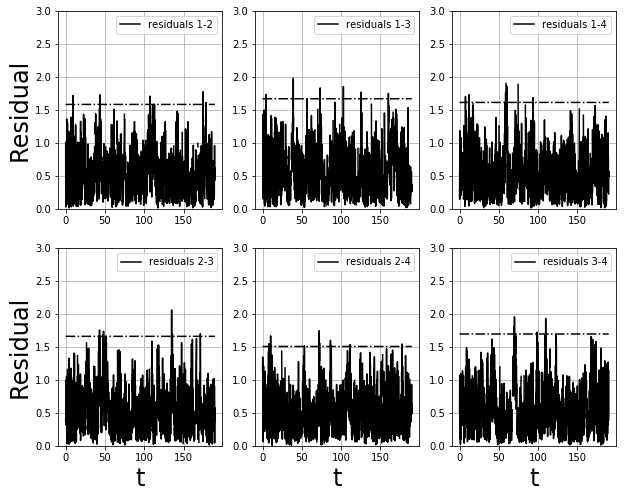

In [26]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'residuals {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot(nominal_timestamps[108:] - nominal_timestamps[108],
             np.ones(distances_no_faults_w1.shape[1]) * \
                     fault_thresholds[i], 'k-.')
    plt.plot(nominal_timestamps[108:] - nominal_timestamps[108],
             distances_no_faults_w1[i,:], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Residual', fontsize=24)

    plt.ylim([0, 3.])
    plt.legend()
    plt.grid()
plt.show()

The distances on the faulty data are shown below.

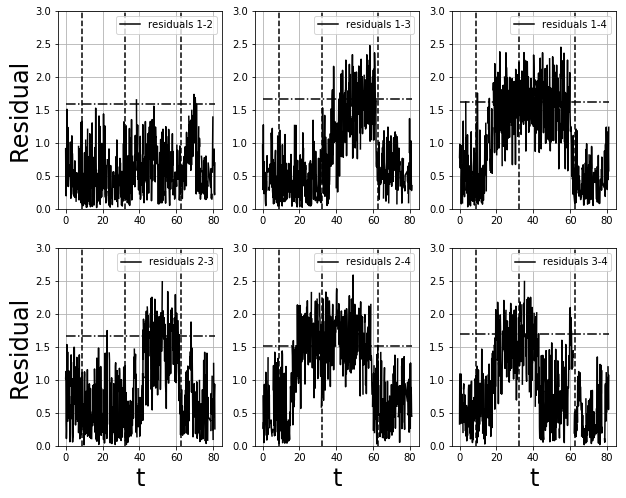

In [27]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'residuals {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot([event_timestamps-faulty_timestamps[108],
              event_timestamps-faulty_timestamps[108]], [0, 3.],
             'k--')
    plt.plot(faulty_timestamps[108:]-faulty_timestamps[108],
             np.ones(faulty_distances_w1.shape[1]) * \
                     fault_thresholds[i], 'k-.')
    plt.plot(faulty_timestamps[108:]-faulty_timestamps[108],
             faulty_distances_w1[i,:], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Residual', fontsize=24)

    plt.ylim([0, 3.])
    plt.legend()
    plt.grid()
plt.show()

# Evaluation

In [28]:
total_nominal = 0.
fp = 0.
for i in range(6):
    fp += len(np.where(distances_no_faults_w1[i] > fault_thresholds[i])[0])
    total_nominal += len(distances_no_faults_w1[i])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [29]:
(fp / total_nominal) * 100.

0.5530973451327433

In [31]:
tp_faulty = 0.
fp_faulty = 0.
fn_faulty = 0.
tn_faulty = 0.
fault_timestamps = faulty_timestamps[109:]-faulty_timestamps[109]
norm_event_timestamps = event_timestamps-faulty_timestamps[109]

region_detections = [[2, 4, 5], [1, 2, 3, 4]]
for i, timestamp in enumerate(fault_timestamps):
    subsequent_events = np.where(norm_event_timestamps > timestamp)[0]
    next_event = -1
    if len(subsequent_events) > 0:
        next_event = subsequent_events[0]
    fault_region = next_event - 1

    # we are not in a faulty region, so any
    # detections are false alarms
    if fault_region < 0:
        for j in range(6):
            if faulty_distances_w1[j][i] > fault_thresholds[j]:
                fp_faulty += 1
            else:
                tn_faulty += 1
    else:
        for j in range(6):
            if j in region_detections[fault_region]:
                # we are in a faulty region and we expect
                # detections for the j-th model, so any
                # missing detections are false negatives
                if faulty_distances_w1[j][i] > fault_thresholds[j]:
                    tp_faulty += 1
                else:
                    fn_faulty += 1
            else:
                # we are in a faulty region, but we don't expect
                # detections for the j-th model, so any
                # detections are false positives
                if faulty_distances_w1[j][i] > fault_thresholds[j]:
                    fp_faulty += 1
                else:
                    tn_faulty += 1

In [32]:
print('True positives: {0}'.format(tp_faulty))
print('True negatives: {0}'.format(tn_faulty))
print('False positives: {0}'.format(fp_faulty))
print('False negatives: {0}'.format(fn_faulty))

True positives: 510.0
True negatives: 2142.0
False positives: 44.0
False negatives: 964.0


In [33]:
precision = tp_faulty / (tp_faulty + fp_faulty)
recall = tp_faulty / (tp_faulty + fn_faulty)

In [34]:
print('Precision: {0}'.format(precision))
print('Recall: {0}'.format(recall))

Precision: 0.9205776173285198
Recall: 0.34599728629579374
